In [49]:
#hide
from utils import *
from fastai2.vision.all import *
from fastai2.vision.widgets import *

In [26]:
key = '13724d0010f84ad0b48678b4b8fbc1ae'

In [27]:
search_images_bing

<function utils.search_images_bing(key, term, min_sz=128)>

In [28]:
results = search_images_bing(key, 'flower')
ims = results.attrgot('content_url')
len(ims)

150

In [29]:
#hide
ims = ['http://3.bp.blogspot.com/-anSqxQWm88Q/TZIdnkD8QXI/AAAAAAAAFCw/xCm_EWninrw/s1600/beautiful-pink-flowers.jpg']

In [30]:
dest = 'images/flower.jpg'
download_url(ims[0], dest)

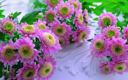

In [31]:
im = Image.open(dest)
im.to_thumb(128,128)

In [34]:
flowers_types = 'rose','orchid', 'sunflower', 'daisy', 'azalea'
path = Path('flowers')

In [35]:
if not path.exists():
    path.mkdir()
    for o in flowers_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} flower')
        download_images(dest, urls=results.attrgot('content_url'))

In [36]:
fns = get_image_files(path)
fns

(#745) [Path('flowers/rose/00000001.jpg'),Path('flowers/rose/00000005.jpg'),Path('flowers/rose/00000004.jpg'),Path('flowers/rose/00000003.jpeg'),Path('flowers/rose/00000009.jpg'),Path('flowers/rose/00000006.jpg'),Path('flowers/rose/00000010.JPG'),Path('flowers/rose/00000013.jpg'),Path('flowers/rose/00000014.jpg'),Path('flowers/rose/00000000.jpg')...]

In [37]:
failed = verify_images(fns)
failed

/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:2860: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:2860: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


(#9) [Path('flowers/rose/00000062.jpg'),Path('flowers/rose/00000081.jpg'),Path('flowers/orchid/00000147.jpg'),Path('flowers/sunflower/00000055.jpg'),Path('flowers/azalea/00000024.jpg'),Path('flowers/azalea/00000088.jpg'),Path('flowers/azalea/00000132.jpg'),Path('flowers/azalea/00000144.jpg'),Path('flowers/azalea/00000145.jpg')]

In [38]:
failed.map(Path.unlink);

### Sidebar: Getting help in jupyter notebooks

### End sidebar

## From data to DataLoaders

In [39]:
flowers = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [40]:
dls = flowers.dataloaders(path)

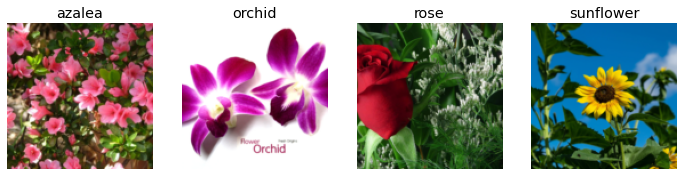

In [41]:
dls.valid.show_batch(max_n=4, nrows=1)

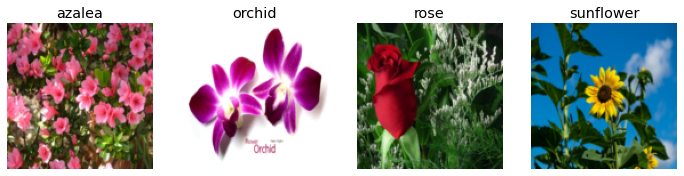

In [42]:
flowers = flowers.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = flowers.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

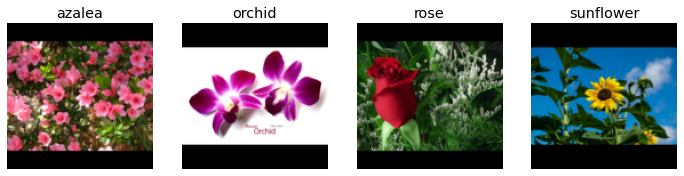

In [43]:
flowers = flowers.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = flowers.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

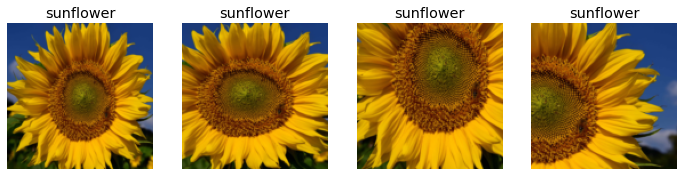

In [44]:
flowers = flowers.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = flowers.dataloaders(path)
dls.train.get_idxs = lambda: Inf.ones
dls.train.show_batch(max_n=4, nrows=1)

### Data augmentation

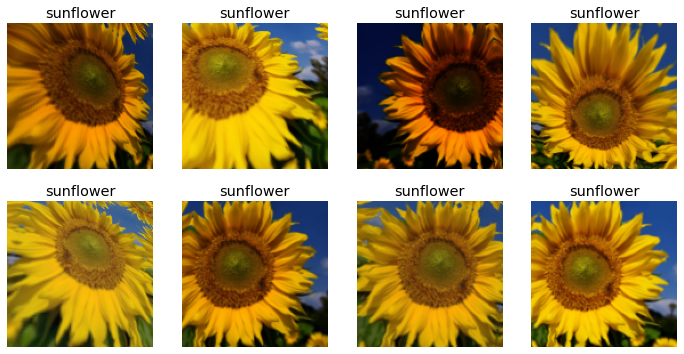

In [45]:
flowers = flowers.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = flowers.dataloaders(path)
dls.train.get_idxs = lambda: Inf.ones
dls.train.show_batch(max_n=8, nrows=2)

## Training your model, and using it to clean your data

In [46]:
flowers = flowers.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = flowers.dataloaders(path)

In [47]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.668043,0.612516,0.209091,00:13


/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.489644,0.278814,0.104545,00:13
1,0.402331,0.187977,0.063636,00:14
2,0.310569,0.184597,0.068182,00:15
3,0.247652,0.189878,0.068182,00:14


/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


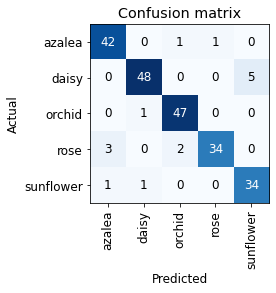

In [50]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

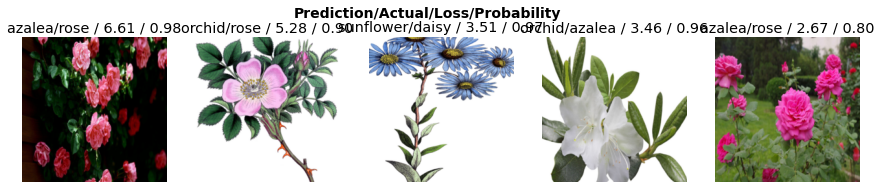

In [51]:
interp.plot_top_losses(5, nrows=1)

In [52]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


## Turning your model into an online application

### Using the model for inference

In [53]:
learn.export()

In [54]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [55]:
learn_inf = load_learner(path/'export.pkl')

In [56]:
learn_inf.predict('images/flower.jpg')

('daisy', tensor(1), tensor([0.1449, 0.4397, 0.3738, 0.0021, 0.0394]))

In [57]:
learn_inf.dls.vocab

(#5) ['azalea','daisy','orchid','rose','sunflower']

### Creating a Notebook app from the model

In [58]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [59]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/flower.jpg'])

In [60]:
img = PILImage.create(btn_upload.data[-1])

In [61]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [62]:
pred,pred_idx,probs = learn_inf.predict(img)

In [63]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: daisy; Probability: 0.4397')

In [64]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [65]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [66]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [67]:
VBox([widgets.Label('Select your flower!'), 
      btn_upload, btn_run, out_pl, lbl_pred])